In [1]:
%matplotlib inline
import glob
# import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from dataset_utils import load_grayscale, img_to_dataset, grid_plot

from tensorflow import keras as K
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## loading the data

In [4]:
data_source = '/net/people/plgmatisz/antibodies/data/original/'
glob.glob(data_source + '*')

['/net/people/plgmatisz/antibodies/data/original/negatives',
 '/net/people/plgmatisz/antibodies/data/original/AMA',
 '/net/people/plgmatisz/antibodies/data/original/nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+homogenny',
 '/net/people/plgmatisz/antibodies/data/original/ACA',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty',
 '/net/people/plgmatisz/antibodies/data/original/fibrilar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/homogenous',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+cytoplazmatyczny',
 '/net/people/plgmatisz/antibodies/data/original/nuclear_dots']

In [5]:
classes_to_load = {
    'ZIA': 'ziarnisty',
    'HOM': 'homogenous',
    'ACA': 'ACA'
}

files_limit = 100

files_dict = {key: glob.glob(f'{data_source}/{dir_}/*')[:files_limit] for key, dir_ in classes_to_load.items()}

for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

ZIA: 100
HOM: 70
ACA: 57


CPU times: user 2.44 s, sys: 392 ms, total: 2.83 s
Wall time: 2.87 s


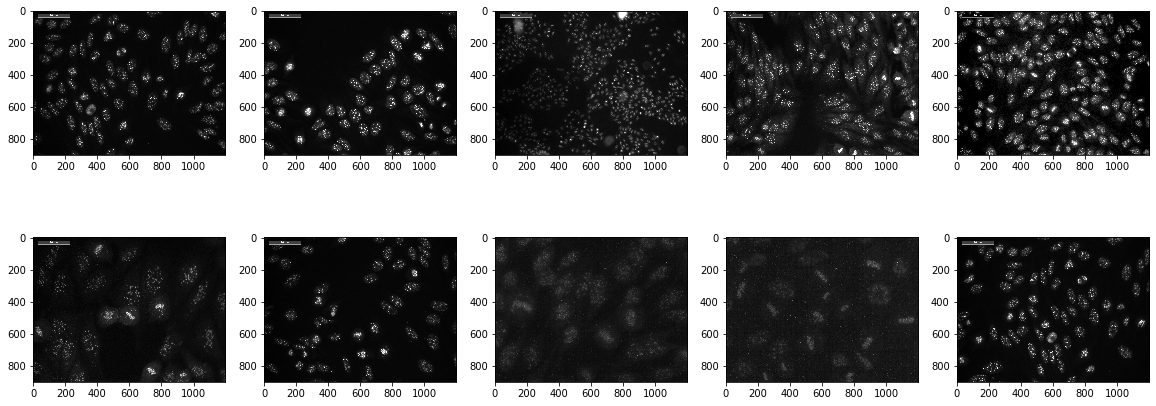

In [13]:
%%time

img_size = (1200, 900)

imgs_dict = {key: np.array([load_grayscale(f, img_size) for f in files]) for key, files in files_dict.items()}

plt.figure(figsize=(20, 16))
grid_plot(imgs_dict['ACA'][-10:], 4, 5, method='imshow', cmap='gray')

## defining datasets

In [14]:
%%time

params = {
    
    # params for detecting ROI
    'roi_window_size': 20,
    'roi_stride': 5,
    'roi_threshold': 3.,
    
    # params for extracting dataset windows
    'img_window_size': 128,
    'img_window_stride': 16,
    'img_neg_threshold': 0.05,
    'img_pos_threshold': 0.3
}

classes_order = ['HOM', 'ZIA', 'ACA']
labels_mapping = {name: label for label, name in enumerate(classes_order)}

train_imgs_count = 30
test_imgs_count = 5

def load_class_dataset(imgs, class_name):
    crops = []
    for img in imgs:
        neg, pos = img_to_dataset(img, params)
        crops.append(pos)
        
    crops = np.concatenate(crops)
    labels = np.full(crops.shape[0], fill_value=labels_mapping[class_name])
    
    return crops, labels
    
train_samples_per_class = 7_000
test_samples_per_class = 1_000

X_train = []
y_train = []

X_test = []
y_test = []

for class_name, imgs in imgs_dict.items():
    train_crops, train_labels = load_class_dataset(imgs[:train_imgs_count], class_name)
    X_train.append(train_crops[:train_samples_per_class])
    y_train.append(train_labels[:train_samples_per_class])
    
    test_crops, test_labels = load_class_dataset(imgs[-test_imgs_count:], class_name)
    X_test.append(test_crops[:test_samples_per_class])
    y_test.append(test_labels[:test_samples_per_class])

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape, X_test.shape)

(21000, 128, 128) (3000, 128, 128)
CPU times: user 43.1 s, sys: 49.4 s, total: 1min 32s
Wall time: 1min 32s


In [15]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([1000, 1000, 1000]))

[1 2 1 1 0 1 2 0 0 1 0 0 0 1 0 2 2 0 0 1]


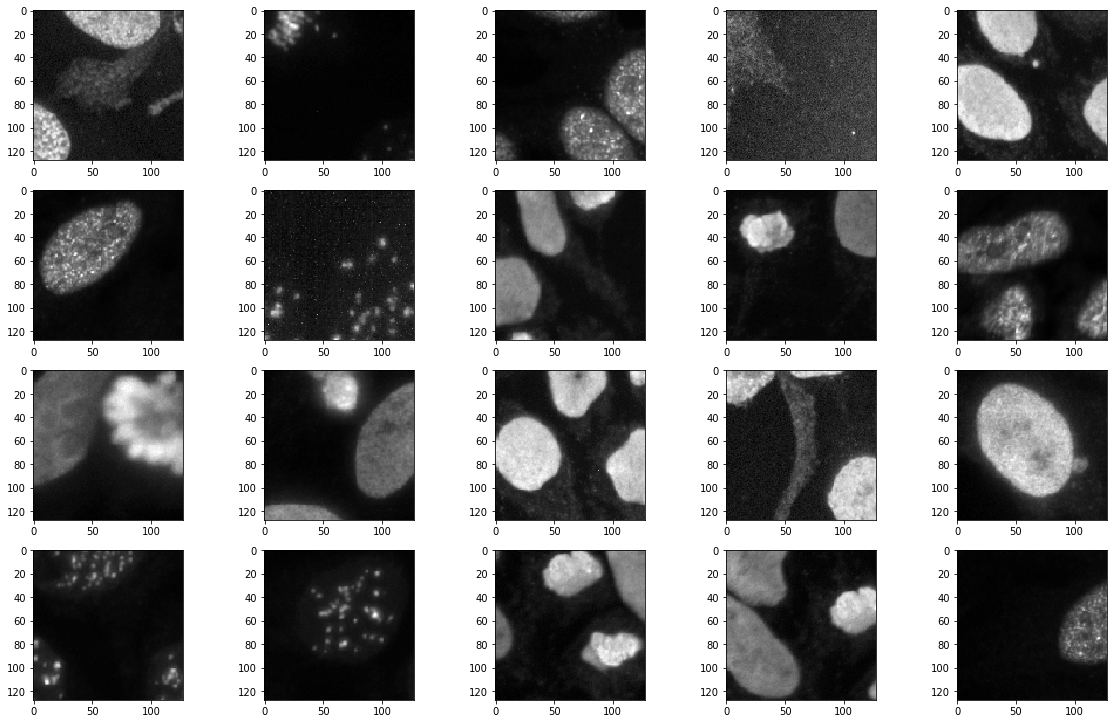

In [16]:
train_indeces = np.array(range(X_train.shape[0]))
rand_train_indeces = np.random.choice(train_indeces, 20)

plt.figure(figsize=(20, 16))
grid_plot(X_train[rand_train_indeces], cmap='gray')

print(y_train[rand_train_indeces])

## network training

In [17]:
model_input = K.layers.Input(shape=(128, 128, 1), name='img')
x = K.layers.Conv2D(8, 11, activation='relu')(model_input)
x = K.layers.Conv2D(8, 11, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Conv2D(8, 7, activation='relu')(x)
x = K.layers.Conv2D(8, 7, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Conv2D(8, 5, activation='relu')(x)
x = K.layers.Conv2D(8, 5, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Flatten()(x)
x = K.layers.Dense(10, activation='relu')(x)
model_output = K.layers.Dense(3, activation='softmax')(x)

model = K.Model(model_input, model_output, name='cells-classifier')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 8)       976       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 8)       7752      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         3144      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 8)         3144      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 8)    

In [18]:
history = model.fit(
    np.expand_dims(X_train, axis=3), y_train,
    epochs=30,
    batch_size=256,
    validation_data=(np.expand_dims(X_test, axis=3), y_test)
)

Train on 21000 samples, validate on 3000 samples
Epoch 1/30
21000/21000 [==============================] - 14s 652us/sample - loss: 1.2105 - acc: 0.3992 - val_loss: 1.4900 - val_acc: 0.3447
Epoch 2/30
21000/21000 [==============================] - 7s 338us/sample - loss: 0.9364 - acc: 0.5346 - val_loss: 1.4257 - val_acc: 0.3570
Epoch 3/30
21000/21000 [==============================] - 7s 337us/sample - loss: 0.8778 - acc: 0.5782 - val_loss: 1.7114 - val_acc: 0.3583
Epoch 4/30
21000/21000 [==============================] - 7s 346us/sample - loss: 0.8543 - acc: 0.5958 - val_loss: 3.8833 - val_acc: 0.3813
Epoch 5/30
21000/21000 [==============================] - 7s 345us/sample - loss: 0.9120 - acc: 0.5505 - val_loss: 2.0387 - val_acc: 0.3847
Epoch 6/30
21000/21000 [==============================] - 7s 346us/sample - loss: 0.8270 - acc: 0.6219 - val_loss: 2.8981 - val_acc: 0.3970
Epoch 7/30
21000/21000 [==============================] - 7s 340us/sample - loss: 0.8146 - acc: 0.6334 - val_l

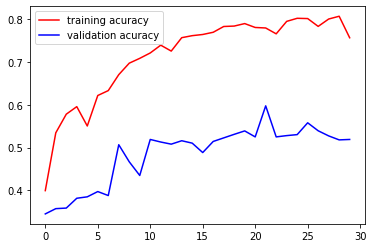

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(acc, c='red', label='training acuracy')
plt.plot(val_acc, c='blue', label='validation acuracy')
plt.legend()

In [20]:
pred_test = model.predict(np.expand_dims(X_test, axis=3)).reshape(-1)

/net/software/local/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


TypeError: Invalid shape (3000, 128, 128) for image data

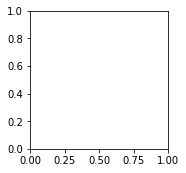

In [21]:
incorrect = (pred_test > 0.5) != y_test


plt.figure(figsize=(16, 30))
grid_plot(X_test[incorrect], 10, 5, vmin=0, vmax=255, cmap='gray')

print(y_test[incorrect][:50])
print(np.round(pred_test[incorrect][:50], decimals=2))